In [3]:
packageVersion("monocle3")
packageVersion("Seurat")
rm(list = ls())  # Clear the environment
options(warn=-1) # Turn off warning message globally
library("monocle3") # Load Monocle
library("Biobase")
library("Seurat")
library("ggplot2")
library("xlsx")
library("scales")

[1] ‘0.2.3.0’

[1] ‘3.2.0’

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

In [3]:
AM1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/AM1.rds")
P35M1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P35M1.rds")
P23M1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P23M1.rds")
Cast1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/Cast.rds")
AM2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/AM2.rds")
P35M2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P35M2.rds")
P23M2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P23M2.rds")
Cast2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/Cast2.rds")
P28MC<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P28MC.rds")
P28MT<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P28MT.rds")
AM<-rbind(AM1,AM2)
P35M<-rbind(P35M1,P35M2)
P23M<-rbind(P23M1,P23M2)
Cast<-rbind(Cast1,Cast2)
AM$group<-rep("AM",dim(AM)[1])
P35M$group<-rep("P35M",dim(P35M)[1])
P23M$group<-rep("P23M",dim(P23M)[1])
Cast$group<-rep("Cast",dim(Cast)[1])
P28MC$group<-rep("P28MC",dim(P28MC)[1])
P28MT$group<-rep("P28MT",dim(P28MT)[1])

In [5]:
Esr1_threshold<-5
Vgat_threshold<-3
AM<-subset(AM,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P35M<-subset(P35M,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P23M<-subset(P23M,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
Cast<-subset(Cast,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P28MC<-subset(P28MC,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P28MT<-subset(P28MT,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
rownames(AM)<-AM$Label
rownames(P35M)<-P35M$Label
rownames(P23M)<-P23M$Label
rownames(Cast)<-Cast$Label
rownames(P28MC)<-P28MC$Label
rownames(P28MT)<-P28MT$Label
metadata<-rbind(AM,P35M)
metadata<-rbind(metadata,P23M)
metadata<-rbind(metadata,Cast)
metadata<-rbind(metadata,P28MC)
metadata<-rbind(metadata,P28MT)
# or
metadata$group<-factor(metadata$group,levels=c("P23M","P28MC","P28MT","P35M","AM","Cast"))

In [6]:
Metadata<-metadata[,c("group","X","Y")]

In [7]:
genes<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Slc32a1","Npy2r","Pgr15l","Ar")

In [8]:
threshold<-0 # user defined threshold
for(i in 1:dim(metadata)[1]){
    for(l in 1:length(genes)){
        if(metadata[i,genes[l]]<threshold){
            metadata[i,genes[l]]<-0
        }
    }
}

# make monocle object

In [10]:
GTF <- read.table(file='/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/features.tsv')
colnames(GTF)<-c("id","gene_short_name","gene_expression")
common<-intersect(genes,GTF$gene_short_name)
GTF<-GTF[GTF$gene_short_name %in% common, ]
GTF<-GTF[!duplicated(GTF$gene_short_name),]
rownames(GTF)<-GTF$gene_short_name
GTF<-GTF[common,]

In [11]:
#210208 10
dim<-10
merge_all_m <-new_cell_data_set(log(as.matrix(t(metadata[,genes]))+1), cell_metadata =Metadata,gene_metadata = GTF)
merge_all_m  <- preprocess_cds(merge_all_m ,  num_dim =dim,use_genes=unique_gene,norm_method = "none",scaling=FALSE)
#merge_all_m  <- preprocess_cds(merge_all_m ,  num_dim =20)
merge_all_m <- reduce_dimension(merge_all_m,reduction_method = "UMAP",preprocess_method = 'PCA')

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invalid!; try increasing work or maxit”


In [12]:
merge_all_m  <- cluster_cells(merge_all_m )
merge_all_m <- learn_graph(merge_all_m,use_partition = FALSE,close_loop = FALSE)
cell_type_color <- c("P23M"= "#697A21","P28MC"= "#20240f","P28MT"= "lightblue","P35M"="#88A0B4","AM" ="#000C3F","Cast"= "#FFDAB9")


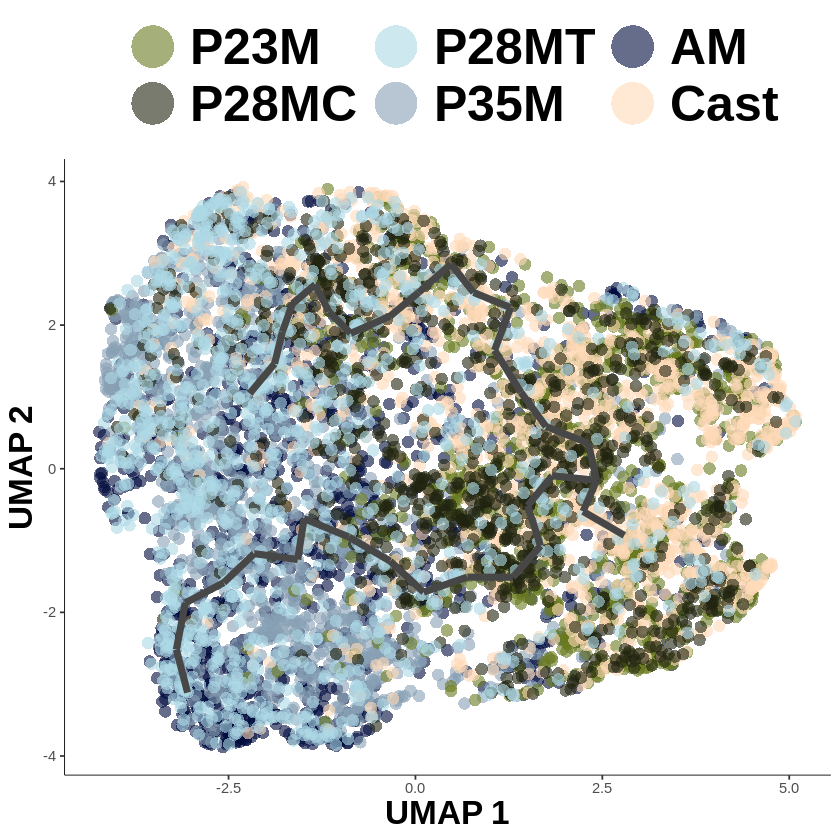

In [13]:
plot_cells(merge_all_m,
           color_cells_by = "group",cell_size =3.5,alpha = 0.6,label_cell_groups = FALSE,trajectory_graph_segment_size = 2,label_roots = FALSE,
           label_leaves=FALSE,cell_stroke = I(0/2),
           label_branch_points=FALSE)+
                     scale_color_manual(values = cell_type_color)+ guides(colour = guide_legend(override.aes = list(size=12)))+theme(title=element_text(size=20,angle=0,face="bold"),strip.text = element_text(size = 40,face="bold")
    ,legend.title=element_blank(), legend.text=element_text(size = 30,face="bold") ,legend.position ="top")
#ggsave(file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/trajectory_stim_male_VgatEsr1_",dim,"threshold",threshold,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf",sep=""),width=10,height=10)

In [14]:
get_earliest_principal_node <- function(merge_all_m, group="P23M"){
  cell_ids <- which(colData(merge_all_m)[, "group"] == group)
  
  closest_vertex <-
  merge_all_m@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(merge_all_m), ])
  root_pr_nodes <-
  igraph::V(principal_graph(merge_all_m)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}
merge_all_m<- order_cells(merge_all_m, root_pr_nodes=get_earliest_principal_node(merge_all_m))

In [15]:
get_earliest_principal_node(merge_all_m)

[1] "Y_19"

In [16]:
pseudotime<-numeric()
for (i in 1:length(merge_all_m@ principal_graph_aux$UMAP$pseudotime)){
    pseudotime[i]<-merge_all_m@ principal_graph_aux$UMAP$pseudotime[[i]]
}

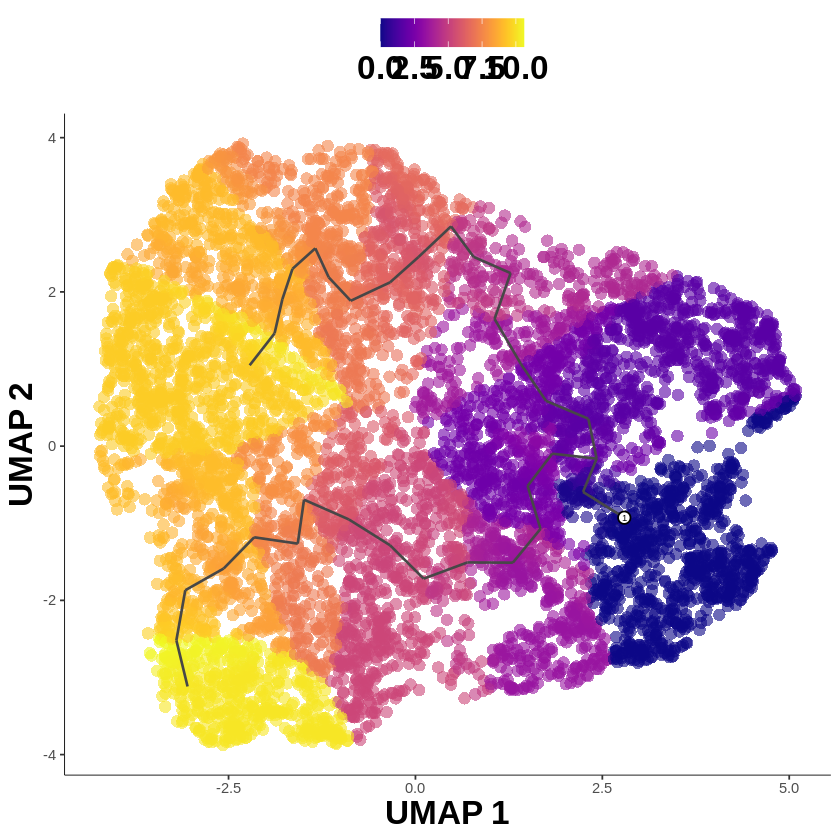

In [17]:
plot_cells(merge_all_m,
           color_cells_by = "pseudotime",cell_size =3.5,alpha = 0.6,label_cell_groups = FALSE,trajectory_graph_segment_size = 0.75,
           label_leaves=FALSE,cell_stroke = I(0/2),
           label_branch_points=FALSE)+
theme(title=element_text(size=20,angle=0,face="bold"),strip.text = element_text(size = 40,face="bold")
    ,legend.title=element_blank(), legend.text=element_text(size = 20,face="bold") ,legend.position ="top")
#ggsave(file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/psedotime_stim_male_VgatEsr1_",dim,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf",sep=""),width=10,height=10)

In [155]:
saveRDS(merge_all_m,file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/Vgat_Esr1_",dim,"merge_all","Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".rds",sep=""))

# Heatmap DEGs along trajectory

In [9]:
Esr1_threshold<-5
Vgat_threshold<-3
dim<-10
threshold<-0

In [10]:
merge_all_m<-readRDS(file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/Vgat_Esr1_",dim,"merge_all","Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".rds",sep=""))

In [11]:
#gene_list<-unique_gene
gene_list<-c("Slc32a1","Esr1","Ar","Npy2r","Pgr15l","Sytl4","Lamp5","Pgr","Nrip1","Acvr1c","Apoc3","Greb1")
max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)
spacing<-10
Pseudotime<-seq(0, ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)), by=ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime))/spacing)
Pseudotime<-Pseudotime[1:spacing]
int<-Pseudotime[2]-Pseudotime[1]
expression<-log(as.matrix(t(metadata[,genes]))+1)
#210112
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)
max_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(gene_list)){
L<-length(Pseudotime)

Cell_number_t<- data.frame("cluster" =Pseudotime, "gene"=(rep(gene_list[i],L))) # do not use c if the gene is factorizsed
#used normalized uncorrected data
for (p in 1:length(Pseudotime)){
barcode<-names(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)[Pseudotime[p]< merge_all_m@principal_graph_aux@listData$UMAP$pseudotime &  merge_all_m@principal_graph_aux@listData$UMAP$pseudotime<Pseudotime[p]+int]
Cell_number_t$avg[p]<-(mean(expression[gene_list[i],barcode])-mean(expression[gene_list[i],]))/sd(expression[gene_list[i],])
}
Cell_number<-rbind(Cell_number_t,Cell_number)
max_number_t<-subset(Cell_number_t,Cell_number_t$avg==max(Cell_number_t$avg))
max_number<-rbind(max_number_t,max_number)    
}
max_number_sort<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)
for (i in 1:length(Pseudotime)){
    temp<-subset(max_number,cluster==Pseudotime[i])
    temp<-temp[order(temp$avg),]
    max_number_sort<-rbind(max_number_sort,temp)}
Cell_number$cluster<-factor(Cell_number$cluster,levels=Pseudotime)
Cell_number$gene<-factor(Cell_number$gene,levels=rev(gene_list))
temp_gene<-rev(unique(max_number_sort$gene))

[1] 10.60214

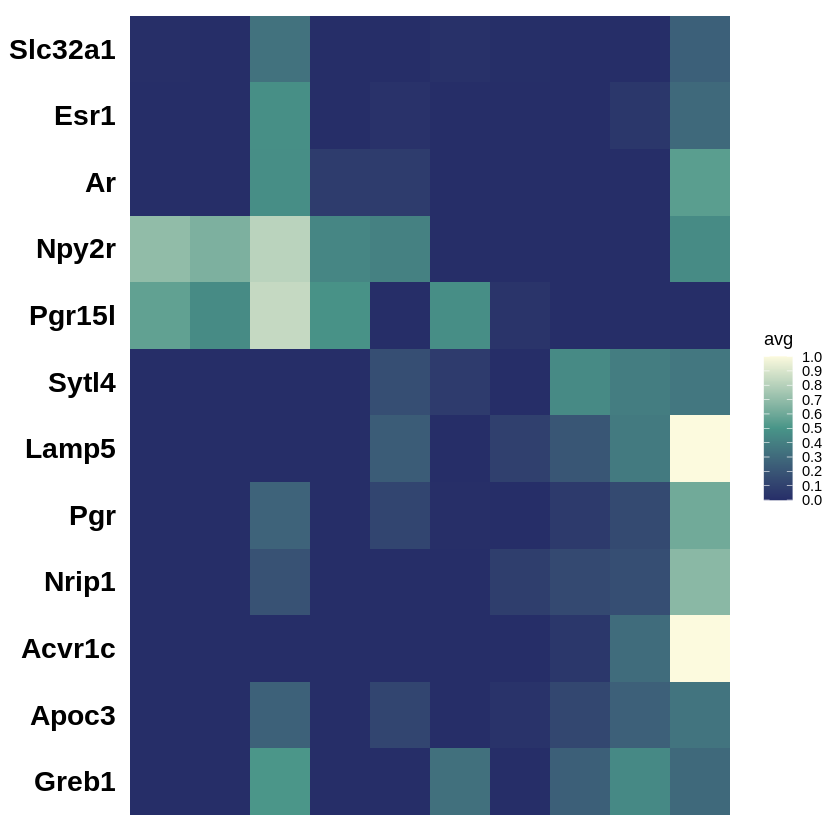

In [13]:
high_C<-"#FCFADE"
middle_C<-"#489588"
low_C<-"#262E68"
low<- 0
high<- 1
p<-ggplot(data = Cell_number, mapping = aes(x = cluster, y = gene,fill =avg)) +
  geom_tile() + scale_fill_gradient2(limits=c(low, high), breaks=seq(low,high,by=0.1),low = low_C,mid=middle_C,high =high_C,  midpoint = (low+high)/2,oob=squish)  #scale_fill_continuous(limits=c(low, high), breaks=seq(low,high,by=0.2),low = "black",high = "yellow", oob=squish)
pp<-p+ylab("gene")+xlab("psedutime")+theme(axis.text.y=element_text(size=17, colour = "black",face="bold"),axis.text.x=element_text(size=0,angle = 0, hjust =0.5,vjust=0.3,colour = "black"),axis.title=element_blank(),plot.title = element_blank(),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "white", size = 0),axis.ticks.y = element_blank(),axis.ticks.x = element_blank())+ggtitle("heatmap marker gene")
print(pp)
ggsave(file=paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/DEG_heatmap_light_DEGtrajectory_BL",dim,"_",low,"_",high,spacing,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,"color_adjusted.pdf"),width=10,height=7,paper="letter")
#dev.off()

# proportion of each group along Pseudotime

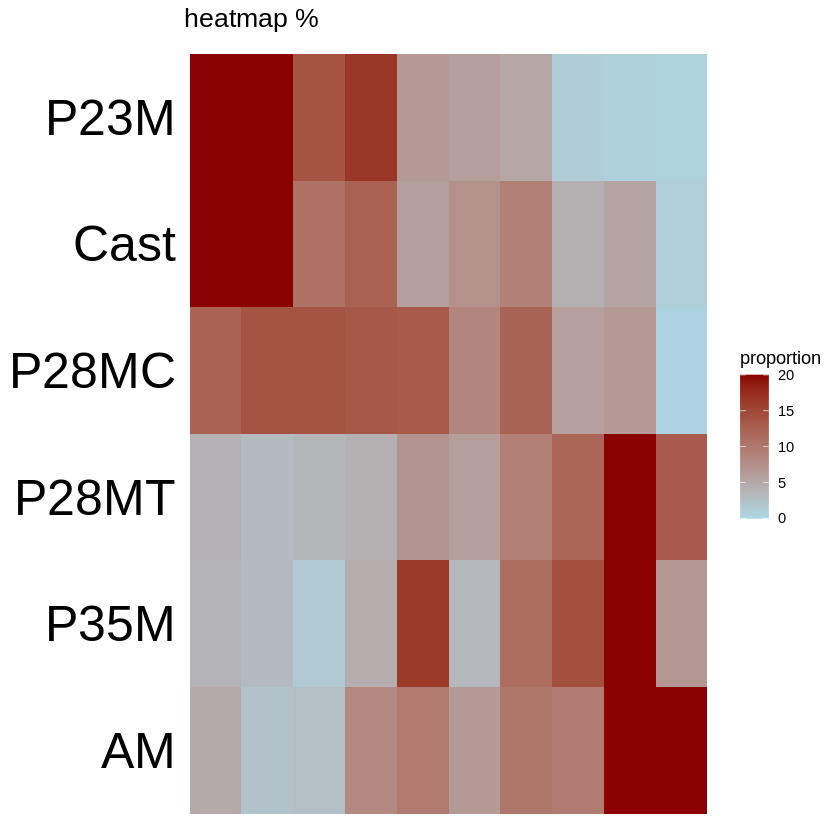

In [30]:
spacing<-10
Pseudotime<-seq(0, ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)), by=ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime))/spacing)
Pseudotime<-Pseudotime[1:spacing]
stim<-c("P23M","Cast","P28MC","P28MT","P35M","AM")
int<-Pseudotime[2]-Pseudotime[1]
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(stim)){
L<-length(Pseudotime)

Cell_number_t<- data.frame("cluster" =Pseudotime, "group"=(rep(stim[i],L))) # do not use c if the gene is factorizsed
#used normalized uncorrected data
for (p in 1:length(Pseudotime)){
barcode<-names(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)[Pseudotime[p]< merge_all_m@principal_graph_aux@listData$UMAP$pseudotime &  merge_all_m@principal_graph_aux@listData$UMAP$pseudotime<Pseudotime[p]+int]
Cell_number_t$proportion[p]<-100*length(intersect(barcode,rownames(subset(metadata,group==stim[i]))))/dim(subset(metadata,group==stim[i]))[1]}
Cell_number<-rbind(Cell_number_t,Cell_number)}
Cell_number$group<-factor(Cell_number$group,levels=rev(stim))
Cell_number$cluster<-factor(Cell_number$cluster,levels=Pseudotime)
low<-0
high<-20
p<-ggplot(data = Cell_number, mapping = aes(x = cluster, y = group,fill =proportion)) +
  geom_tile() + scale_fill_continuous(limits=c(low, high), breaks=seq(low,high,by=5),low = "lightblue",high = "darkred", oob=squish)
pp<-p+ylab("proportion %")+xlab("psedutime")+theme(axis.text.y=element_text(size=30, colour = "black"),axis.text.x=element_blank(),axis.title=element_blank(),plot.title = element_text(size=16),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "white", size = 0),axis.ticks.y = element_blank(),axis.ticks.x = element_blank())+ggtitle("heatmap %")
print(pp)
#ggsave(file=paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/heatmap_light_proportionalongtrajectory",dim,"_",low,"_",high,spacing,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf"),width=10,height=2.5)

# spatial analysis

In [49]:
metadata$Pseudotime<-merge_all_m@principal_graph_aux@listData$UMAP$pseudotime

In [50]:
stim<-c("P23M","Cast","P28MC","P28MT","P35M","AM")

In [51]:
metadata$Y<-metadata$Y*(-1.36)

In [52]:
group<-stim
max<-max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)
for(i in 1:length(group)){
stim<-group[i]
meta<-subset(metadata,group==stim)
#meta<-meta[order(meta$Pseudotime),]
p<-ggplot(data=meta,aes(x=X,y=Y,color=Pseudotime))+geom_point( size=4)+ylab("Dorso-Ventral")+xlab("Medial-Lateral")+coord_fixed()+
scale_color_gradient(limits=c(0, max), breaks=seq(0,max,5),low = "darkblue",high = "yellow2", oob=squish)+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
,panel.background = element_rect(fill = "transparent",colour = NA),plot.background = element_rect(fill = "transparent",colour = NA), axis.line = element_line(colour = "black"))+ggtitle("Spatial distribution")+xlim(-0.5,1)+ylim(-1.8,0)
pdf(paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/space_distribution",dim,stim,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf"),width=10,height=10, bg="transparent")
    print(p)
    dev.off()
}

In [27]:
#210206 for fig tiff
group<-stim
max<-max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)
for(i in 1:length(group)){
stim<-group[i]
meta<-subset(metadata,group==stim)
meta<-meta[order(meta$Pseudotime),]
ggplot(data=meta,aes(x=X,y=Y,color=Pseudotime))+geom_point( size=4)+ylab("Dorso-Ventral")+xlab("Medial-Lateral")+coord_fixed()+
scale_color_gradient(limits=c(0, max), breaks=seq(0,max,5),low = "darkblue",high = "yellow2", oob=squish)+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
,panel.background = element_rect(fill = "transparent",colour = NA),plot.background = element_rect(fill = "transparent",colour = NA), axis.line = element_line(colour = "black"))+ggtitle("Spatial distribution")+xlim(-0.5,1)+ylim(0,1.8)
ggsave(file=paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/space_distribution",dim,stim,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".tiff"),device="tiff",width=10,height=10,dpi=700,bg="transparent")

}

In [34]:
group<-stim
max<-max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)
for(i in 1:length(group)){
stim<-group[i]
meta<-subset(metadata,group==stim)
#meta<-meta[order(meta$Pseudotime),]
p<-ggplot(data=meta,aes(x=X,y=Y,color=Pseudotime))+geom_point( size=4)+ylab("Dorso-Ventral")+xlab("Medial-Lateral")+coord_fixed()+
scale_color_gradient(limits=c(0, max), breaks=seq(0,max,5),low = "darkblue",high = "yellow2", oob=squish)+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
,panel.background = element_rect(fill = "transparent",colour = NA),plot.background = element_rect(fill = "transparent",colour = NA), axis.line = element_line(colour = "black"))+ggtitle("Spatial distribution")+xlim(-0.5,1)+ylim(-1.8,0)
png(paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/space_distribution",dim,stim,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".png"),width=10,height=10, units     = "in",res=1600,bg="transparent")
    print(p)
    dev.off()
}

# predicted scRNAseq expression

In [122]:
# import scRNAseqdata, use male data of Esr1-Vgat as reference
MPOA.integrated<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/MPOA.integrated.rds")

new.ident <- c("Mix1","Vgat1","Vglu1","Vgat2","Vgat3","Vgat4","Mix2","Vglu2","Vgat5","Vglu3","Vglu4","Vgat6","Vgat7","Vgat8","Vglu5","Vglu6","Vgat9","Vgat10","Vgat11","Vglu7","Vgat12","Vgat13","Vgat14","Vgat15","Vglu8","Vglu9","Vgat16","Vglu10","Vgat17","Vgat18","Vgat19","Vglu11","Vglu12","Ambiguous1","Mix3","Vgat20")
names(x = new.ident) <- levels(x =MPOA.integrated)
MPOA.integrated<- RenameIdents(object =MPOA.integrated, new.ident)
MPOA.integrated<-subset(MPOA.integrated,cells=rownames(subset(MPOA.integrated@meta.data,stim=="AM"|stim=="P35M"|stim=="P23M"|stim=="Cast")))
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(MPOA.integrated@assays$RNA@data[,which(Idents(object=MPOA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
}
Hormone_rich<-c(Vgat2_barcode,Vgat4_barcode,Vgat16_barcode)
BC<-intersect(rownames(MPOA.integrated@meta.data),Hormone_rich)
MPOA.integrated<-subset(MPOA.integrated,cells=BC)
# HCR (log 1p without scaling)

# parameter setting
gene_list<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Slc32a1","Npy2r","Pgr15l","Ar")
predicted_seq <-  data.frame(Date=as.Date(character()),
                 File=character(), 
                 User=character(), 
                 stringsAsFactors=FALSE) 
predicted_seq <- data.frame(matrix(ncol = length(gene_list), nrow = dim(MPOA.integrated@meta.data)[1]))
colnames(predicted_seq)<-gene_list

for(p in 1:length(gene_list)){

remove<-c(gene_list[p],"Slc32a1") # change it
Esr1_threshold<-5
Vgat_threshold<-3
# import scRNAseqdata, use male data of Esr1-Vgat as reference
MPOA.integrated<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/MPOA.integrated.rds")

new.ident <- c("Mix1","Vgat1","Vglu1","Vgat2","Vgat3","Vgat4","Mix2","Vglu2","Vgat5","Vglu3","Vglu4","Vgat6","Vgat7","Vgat8","Vglu5","Vglu6","Vgat9","Vgat10","Vgat11","Vglu7","Vgat12","Vgat13","Vgat14","Vgat15","Vglu8","Vglu9","Vgat16","Vglu10","Vgat17","Vgat18","Vgat19","Vglu11","Vglu12","Ambiguous1","Mix3","Vgat20")
names(x = new.ident) <- levels(x =MPOA.integrated)
MPOA.integrated<- RenameIdents(object =MPOA.integrated, new.ident)
MPOA.integrated<-subset(MPOA.integrated,cells=rownames(subset(MPOA.integrated@meta.data,stim=="AM"|stim=="P35M"|stim=="P23M"|stim=="Cast")))
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(MPOA.integrated@assays$RNA@data[,which(Idents(object=MPOA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
}
Hormone_rich<-c(Vgat2_barcode,Vgat4_barcode,Vgat16_barcode)
BC<-intersect(rownames(MPOA.integrated@meta.data),Hormone_rich)
MPOA.integrated<-subset(MPOA.integrated,cells=BC)
# HCR (log 1p without scaling)

AM1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/AM1.rds")
P35M1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P35M1.rds")
P23M1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P23M1.rds")
Cast1<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/Cast1.rds")
AM2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/AM2.rds")
P35M2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P35M2.rds")
P23M2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P23M2.rds")
Cast2<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/Cast2.rds")
P28MC<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P28MC.rds")
P28MT<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/P28MT.rds")
AM<-rbind(AM1,AM2)
P35M<-rbind(P35M1,P35M2)
P23M<-rbind(P23M1,P23M2)
Cast<-rbind(Cast1,Cast2)
AM$group<-rep("AM",dim(AM)[1])
P35M$group<-rep("P35M",dim(P35M)[1])
P23M$group<-rep("P23M",dim(P23M)[1])
Cast$group<-rep("Cast",dim(Cast)[1])
P28MC$group<-rep("P28MC",dim(P28MC)[1])
P28MT$group<-rep("P28MT",dim(P28MT)[1])

AM<-subset(AM,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P35M<-subset(P35M,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P23M<-subset(P23M,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
Cast<-subset(Cast,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P28MC<-subset(P28MC,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
P28MT<-subset(P28MT,Esr1>=Esr1_threshold & Slc32a1>=Vgat_threshold)
rownames(AM)<-AM$Label
rownames(P35M)<-P35M$Label
rownames(P23M)<-P23M$Label
rownames(Cast)<-Cast$Label
rownames(P28MC)<-P28MC$Label
rownames(P28MT)<-P28MT$Label
metadata<-rbind(AM,P35M)
metadata<-rbind(metadata,P23M)
metadata<-rbind(metadata,Cast)
metadata<-rbind(metadata,P28MC)
metadata<-rbind(metadata,P28MT)

metadata$group<-factor(metadata$group,levels=c("P23M","P28MC","P28MT","P35M","AM","Cast"))
genes<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Slc32a1","Npy2r","Pgr15l","Ar")
genes<-genes[genes!=remove]

unique_gene<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Npy2r","Pgr15l","Ar")
unique_gene<-unique_gene[unique_gene!=remove]


HCR.data<-t(metadata[,genes])
HCR<- CreateSeuratObject(counts = HCR.data, min.cells = 0, min.features = 0, project = "10X_MPOA")
HCR@meta.data$stim <- metadata$group
HCR<- NormalizeData(object = HCR,verbose = FALSE) 
library(Matrix)
log1p<-Matrix(log(as.matrix(t(metadata[,genes]))+1), sparse = TRUE) 
HCR@assays$RNA@data<-log1p # we do not do scaling so replace it simple log1p
HCR <- ScaleData(HCR)
HCR <- RunPCA(HCR,features=unique_gene)
HCR <- FindNeighbors(HCR, dims = 1:9)
HCR<- FindClusters(HCR, resolution = 0.6)


# feature transfer
DefaultAssay(HCR) <- 'RNA'
DefaultAssay(MPOA.integrated) <- 'RNA'
VariableFeatures(HCR)<-c(unique_gene,remove)
VariableFeatures(MPOA.integrated)<-unique_gene # this is important
POA.anchors <- FindTransferAnchors(reference = HCR, query = MPOA.integrated, reduction = "cca", dims = 1:15)
#feature<- log(t(as.matrix(metadata[,remove]))+1) # 210202 change
feature<- t(as.matrix(metadata[,remove]))
predictions <- TransferData(anchorset = POA.anchors, refdata =  feature, weight.reduction="cca",  dims = 1:15)
MPOA.integrated@meta.data[,remove[1]]<-predictions@data[remove[1],]

predicted_seq[,remove[1]]<-MPOA.integrated@meta.data[remove[1]]
}

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Greb1, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar, Pgr 
PC_ 2 
Positive:  Acvr1c, Lamp5, Greb1, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Greb1, Lamp5, Acvr1c 
PC_ 3 
Positive:  Acvr1c, Lamp5, Nrip1, Pgr15l, Apoc3, Npy2r, Pgr, Ar, Esr1, Greb1 
Negative:  Greb1, Esr1, Ar, Pgr, Npy2r, Apoc3, Pgr15l, Nrip1, Lamp5, Acvr1c 
PC_ 4 
Positive:  Acvr1c, Npy2r, Greb1, Lamp5, Ar, Pgr, Pgr15l, Esr1, Nrip1, Apoc3 
Negative:  Apoc3, Nrip1, Esr1, Pgr15l, Pgr, Ar, Lamp5, Greb1, Npy2r, Acvr1c 
PC_ 5 
Positive:  Pgr15l, A

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 208679

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7264
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5083 anchors

Filtering anchors

	Retained 3075 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar 
	   Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c 
	   Sytl4 
PC_ 3 
Positive:  Greb1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7250
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4987 anchors

Filtering anchors

	Retained 3121 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Nrip1, Esr1, Apoc3, Lamp5, Acvr1c, Sytl4, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Sytl4, Acvr1c, Lamp5, Apoc3, Esr1, Nrip1, Ar, Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4 
PC_ 3 
Positive:  Sytl4, Apoc3, Esr1, Nrip1, Npy2r, Pgr, Pgr15l, Ar, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 212306

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7355
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5060 anchors

Filtering anchors

	Retained 2989 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar 
	   Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c 
	   Sytl4 
PC_ 3 
Positive:  Greb1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7250
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4987 anchors

Filtering anchors

	Retained 3121 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Greb1, Acvr1c, Sytl4, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Sytl4, Acvr1c, Greb1, Apoc3, Nrip1, Esr1, Ar, Pgr 
PC_ 2 
Positive:  Sytl4, Greb1, Acvr1c, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Acvr1c, Greb1, Sytl4 
PC_ 3 
Positive:  Greb1, Esr1, Npy2r, Sytl4, Ar, Pgr15l, Pgr, Apoc3, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 211237

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7304
Number of communities: 6
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5033 anchors

Filtering anchors

	Retained 2996 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar 
	   Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c 
	   Sytl4 
PC_ 3 
Positive:  Greb1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7250
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4987 anchors

Filtering anchors

	Retained 3121 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Esr1, Ar, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c, Sytl4 
PC_ 3 
Positive:  Greb1, Sytl4, Esr1, Npy2r, Apoc3, Ar, Pgr15

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207609

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7211
Number of communities: 6
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5021 anchors

Filtering anchors

	Retained 3195 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar 
	   Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c 
	   Sytl4 
PC_ 3 
Positive:  Greb1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7250
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4987 anchors

Filtering anchors

	Retained 3121 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar 
	   Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Npy2r 
	   Pgr15l 
Negative:  Pgr15l, Npy2r, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c 
	   Sytl4 
PC_ 3 
Positive:  Greb1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7250
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5028 anchors

Filtering anchors

	Retained 3148 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Nrip1, Esr1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Pgr15l 
Negative:  Pgr15l, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Esr1, Nrip1, Ar, Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Ar, Pgr15l 
Negative:  Pgr15l, Ar, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c, Sytl4 
PC_ 3 
Positive:  Greb1, Esr1, Sytl4, Apoc3, Pgr, Ar, Pgr15l, Nrip1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 209263

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7231
Number of communities: 6
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4986 anchors

Filtering anchors

	Retained 3124 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Ar, Esr1, Nrip1, Apoc3, Lamp5, Acvr1c, Sytl4, Greb1, Npy2r 
Negative:  Npy2r, Greb1, Sytl4, Acvr1c, Lamp5, Apoc3, Nrip1, Esr1, Ar, Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Ar, Esr1, Npy2r 
Negative:  Npy2r, Esr1, Ar, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c, Sytl4 
PC_ 3 
Positive:  Greb1, Sytl4, Esr1, Apoc3, Npy2r, Pgr, Ar, Nrip1, Lamp5

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 208066

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7237
Number of communities: 7
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5044 anchors

Filtering anchors

	Retained 2854 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
PC_ 1 
Positive:  Pgr, Nrip1, Esr1, Apoc3, Lamp5, Sytl4, Acvr1c, Greb1, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Greb1, Acvr1c, Sytl4, Lamp5, Apoc3, Esr1, Nrip1, Pgr 
PC_ 2 
Positive:  Sytl4, Acvr1c, Greb1, Lamp5, Apoc3, Nrip1, Pgr, Esr1, Npy2r, Pgr15l 
Negative:  Pgr15l, Npy2r, Esr1, Pgr, Nrip1, Apoc3, Lamp5, Greb1, Acvr1c, Sytl4 
PC_ 3 
Positive:  Greb1, Sytl4, Esr1, Npy2r, Apoc3, Pgr, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7566
Number of edges: 207104

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7219
Number of communities: 6
Elapsed time: 0 seconds


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4987 anchors

Filtering anchors

	Retained 3121 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Transfering 2 features onto reference data



In [123]:
rownames(predicted_seq)<-rownames(MPOA.integrated@meta.data)
predicted_seq$group<-MPOA.integrated@meta.data$stim

In [124]:
saveRDS(predicted_seq,"/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/predicted_seq_15.rds")

[1] "Sytl4"

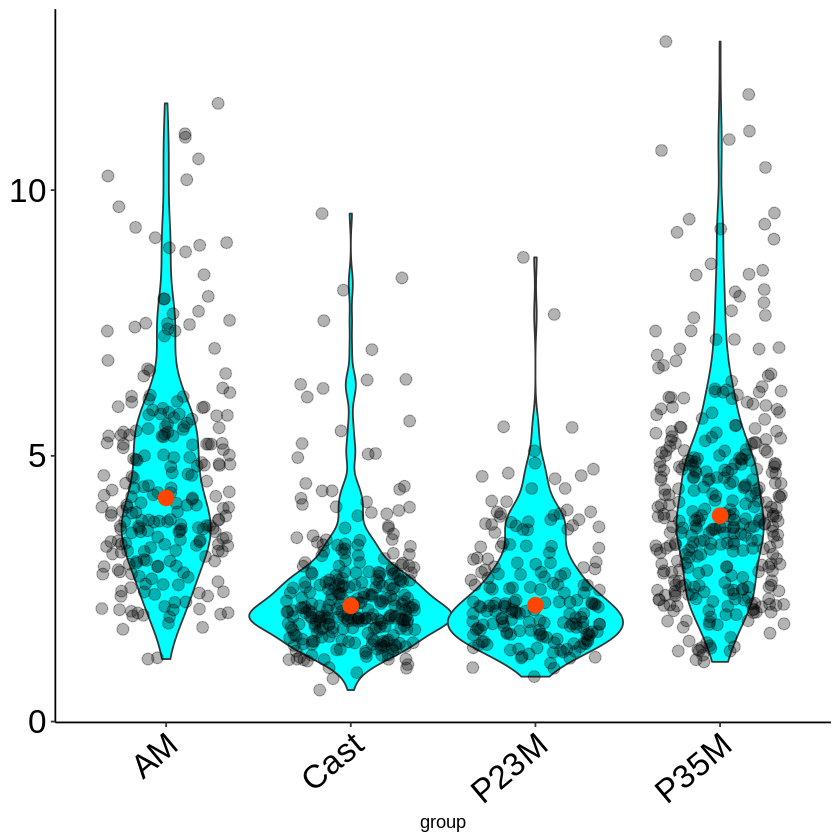

In [125]:
gene_list<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Slc32a1","Npy2r","Pgr15l","Ar")
gene<-gene_list[1]
gene
P<-ggplot(predicted_seq,aes(x=group,y=eval(parse(text=gene))))
P+geom_violin(width=1.1,fill="cyan")+
geom_jitter(position = position_jitter(0.35), alpha = 0.3,size=3) +stat_summary(fun.y=median, geom="point", size=4, color="orange red")+
   theme(axis.title.y=element_blank(),axis.text.y=element_text(size=20,color="black"),axis.text.x=element_text(size=20,angle = 40, hjust = 1,color="black"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),plot.title=element_text(size=30,face="bold",hjust=0.5))

In [ ]:
#constructing trajectory using predicted seq

In [15]:
# import scRNAseqdata, use male data of Esr1-Vgat as reference
MPOA.integrated<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/MPOA.integrated.rds")

new.ident <- c("Mix1","Vgat1","Vglu1","Vgat2","Vgat3","Vgat4","Mix2","Vglu2","Vgat5","Vglu3","Vglu4","Vgat6","Vgat7","Vgat8","Vglu5","Vglu6","Vgat9","Vgat10","Vgat11","Vglu7","Vgat12","Vgat13","Vgat14","Vgat15","Vglu8","Vglu9","Vgat16","Vglu10","Vgat17","Vgat18","Vgat19","Vglu11","Vglu12","Ambiguous1","Mix3","Vgat20")
names(x = new.ident) <- levels(x =MPOA.integrated)
MPOA.integrated<- RenameIdents(object =MPOA.integrated, new.ident)
MPOA.integrated<-subset(MPOA.integrated,cells=rownames(subset(MPOA.integrated@meta.data,stim=="AM"|stim=="P35M"|stim=="P23M"|stim=="Cast")))
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(MPOA.integrated@assays$RNA@data[,which(Idents(object=MPOA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
}
Hormone_rich<-c(Vgat2_barcode,Vgat4_barcode,Vgat16_barcode)
BC<-intersect(rownames(MPOA.integrated@meta.data),Hormone_rich)
MPOA.integrated<-subset(MPOA.integrated,cells=BC)

In [16]:
genes<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Slc32a1","Npy2r","Pgr15l","Ar")
GTF <- read.table(file='/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/features.tsv')
colnames(GTF)<-c("id","gene_short_name","gene_expression")
common<-intersect(genes,GTF$gene_short_name)
GTF<-GTF[GTF$gene_short_name %in% common, ]
GTF<-GTF[!duplicated(GTF$gene_short_name),]
rownames(GTF)<-GTF$gene_short_name
GTF<-GTF[common,]

In [17]:
#predicted_seq

In [18]:
predicted_seq<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/predicted_seq_15.rds")
genes<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Slc32a1","Npy2r","Pgr15l","Ar")

unique_gene<-c("Sytl4","Acvr1c","Greb1","Nrip1","Lamp5","Apoc3","Pgr","Esr1","Npy2r","Pgr15l","Ar")
#210112
dim<-10
merge_all_m <-new_cell_data_set(as.matrix(t(predicted_seq[,genes])), cell_metadata =predicted_seq,gene_metadata = GTF) # I think the predicted value is already log-normalized like
merge_all_m  <- preprocess_cds(merge_all_m ,  num_dim =dim,use_genes=unique_gene,norm_method = c("none"),scaling=FALSE)

merge_all_m <- reduce_dimension(merge_all_m,reduction_method = "UMAP",preprocess_method = 'PCA')
merge_all_m  <- cluster_cells(merge_all_m )
merge_all_m <- learn_graph(merge_all_m,use_partition = FALSE)
cell_type_color <- c("P23M"= "#697A21","P28MC"= "#20240f","P28MT"= "#728aed","P35M"="#88A0B4","AM" ="#000C3F","Cast"= "#FFDAB9")
Esr1_threshold<-5
Vgat_threshold<-3
dim<-10
threshold<-0

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invalid!; try increasing work or maxit”


  |======================================================================| 100%


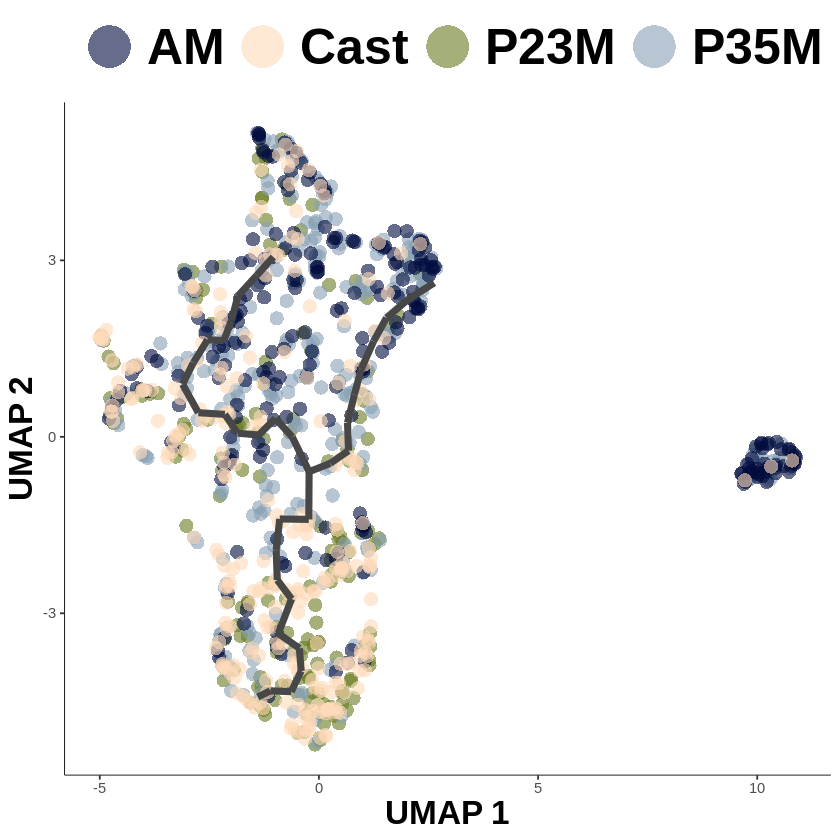

In [147]:
plot_cells(merge_all_m,
           color_cells_by = "group",cell_size =4,alpha = 0.6,label_cell_groups = FALSE,trajectory_graph_segment_size = 2,label_roots = FALSE,
           label_leaves=FALSE,cell_stroke = I(0/2),
           label_branch_points=FALSE)+
                     scale_color_manual(values = cell_type_color)+ guides(colour = guide_legend(override.aes = list(size=12)))+theme(title=element_text(size=20,angle=0,face="bold"),strip.text = element_text(size = 40,face="bold")
    ,legend.title=element_blank(), legend.text=element_text(size = 30,face="bold") ,legend.position ="top")
ggsave(file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/trajectory_stim_male_VgatEsr1_",dim,"threshold",threshold,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf",sep=""),width=10,height=10)

In [19]:
get_earliest_principal_node <- function(merge_all_m, group="P23M"){
  cell_ids <- which(colData(merge_all_m)[, "group"] == group)
  
  closest_vertex <-
  merge_all_m@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(merge_all_m), ])
  root_pr_nodes <-
  igraph::V(principal_graph(merge_all_m)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}
merge_all_m<- order_cells(merge_all_m, root_pr_nodes=get_earliest_principal_node(merge_all_m))
pseudotime<-numeric()
for (i in 1:length(merge_all_m@ principal_graph_aux$UMAP$pseudotime)){
    pseudotime[i]<-merge_all_m@ principal_graph_aux$UMAP$pseudotime[[i]]
}

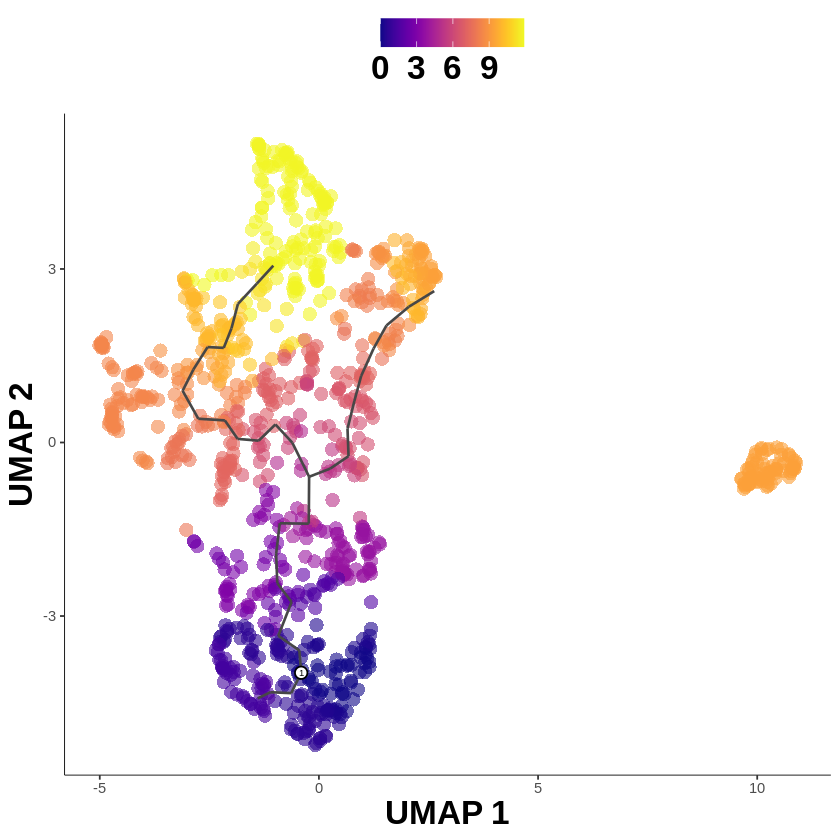

In [149]:
plot_cells(merge_all_m,
           color_cells_by = "pseudotime",cell_size =4,alpha = 0.6,label_cell_groups = FALSE,trajectory_graph_segment_size = 0.75,
           label_leaves=FALSE,cell_stroke = I(0/2),
           label_branch_points=FALSE)+
theme(title=element_text(size=20,angle=0,face="bold"),strip.text = element_text(size = 40,face="bold")
    ,legend.title=element_blank(), legend.text=element_text(size = 20,face="bold") ,legend.position ="top")
ggsave(file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/psedotime_stim_male_VgatEsr1_",dim,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf",sep=""),width=10,height=10)

In [20]:
spacing<-15
Pseudotime<-seq(0, ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)), by=ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime))/spacing)
Pseudotime<-Pseudotime[1:spacing]
group<-c("P23M","Cast","P35M","AM")
int<-Pseudotime[2]-Pseudotime[1]
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(group)){
L<-length(Pseudotime)

Cell_number_t<- data.frame("cluster" =Pseudotime, "stim"=(rep(group[i],L))) # do not use c if the gene is factorizsed
#used normalized uncorrected data
for (p in 1:length(Pseudotime)){
barcode<-names(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)[Pseudotime[p]< merge_all_m@principal_graph_aux@listData$UMAP$pseudotime &  merge_all_m@principal_graph_aux@listData$UMAP$pseudotime<Pseudotime[p]+int]
Cell_number_t$proportion[p]<-100*length(intersect(barcode,rownames(subset(MPOA.integrated@meta.data,stim==group[i]))))/dim(subset(MPOA.integrated@meta.data,stim==group[i]))[1]}
Cell_number<-rbind(Cell_number_t,Cell_number)}

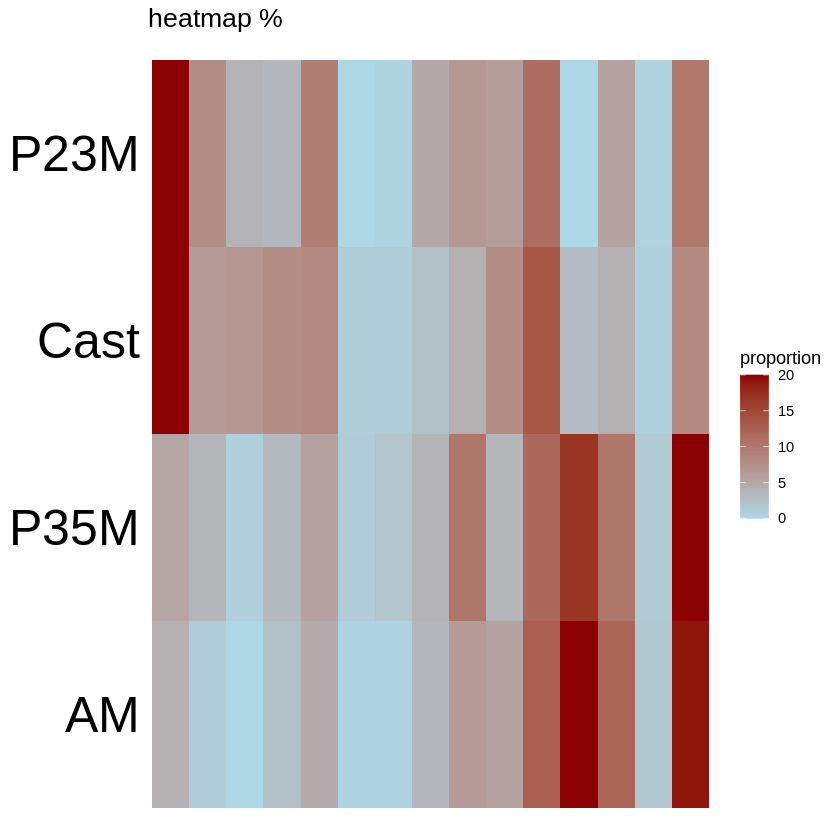

In [152]:
Cell_number$group<-factor(Cell_number$stim,levels=rev(group))
Cell_number$cluster<-factor(Cell_number$cluster,levels=Pseudotime)
low<-0
high<-20
p<-ggplot(data = Cell_number, mapping = aes(x = cluster, y = stim,fill =proportion)) +
  geom_tile() + scale_fill_continuous(limits=c(low, high), breaks=seq(low,high,by=5),low = "lightblue",high = "darkred", oob=squish)
pp<-p+ylab("proportion %")+xlab("psedutime")+theme(axis.text.y=element_text(size=30, colour = "black"),axis.text.x=element_blank(),axis.title=element_blank(),plot.title = element_text(size=16),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "white", size = 0),axis.ticks.y = element_blank(),axis.ticks.x = element_blank())+ggtitle("heatmap %")
print(pp)
ggsave(file=paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/heatmap_light_proportionalongtrajectory",dim,"_",low,"_",high,spacing,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,".pdf"),width=10,height=2.5)

In [22]:
#gene_list<-unique_gene
gene_list<-c("Slc32a1","Esr1","Ar","Npy2r","Pgr15l","Sytl4","Lamp5","Pgr","Nrip1","Acvr1c","Apoc3","Greb1")
max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)
spacing<-15
Pseudotime<-seq(0, ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)), by=ceiling(max(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime))/spacing)
Pseudotime<-Pseudotime[1:spacing]
int<-Pseudotime[2]-Pseudotime[1]
expression<-as.matrix(t(predicted_seq[,genes]))
#210112
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)
max_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(gene_list)){
L<-length(Pseudotime)

Cell_number_t<- data.frame("cluster" =Pseudotime, "gene"=(rep(gene_list[i],L))) # do not use c if the gene is factorizsed
#used normalized uncorrected data
for (p in 1:length(Pseudotime)){
barcode<-names(merge_all_m@principal_graph_aux@listData$UMAP$pseudotime)[Pseudotime[p]< merge_all_m@principal_graph_aux@listData$UMAP$pseudotime &  merge_all_m@principal_graph_aux@listData$UMAP$pseudotime<Pseudotime[p]+int]
Cell_number_t$avg[p]<-(mean(expression[gene_list[i],barcode])-mean(expression[gene_list[i],]))/sd(expression[gene_list[i],])
}
Cell_number<-rbind(Cell_number_t,Cell_number)
max_number_t<-subset(Cell_number_t,Cell_number_t$avg==max(Cell_number_t$avg))
max_number<-rbind(max_number_t,max_number)    
}
max_number_sort<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)
for (i in 1:length(Pseudotime)){
    temp<-subset(max_number,cluster==Pseudotime[i])
    temp<-temp[order(temp$avg),]
    max_number_sort<-rbind(max_number_sort,temp)}
Cell_number$cluster<-factor(Cell_number$cluster,levels=Pseudotime)
Cell_number$gene<-factor(Cell_number$gene,levels=rev(gene_list))
temp_gene<-rev(unique(max_number_sort$gene))

[1] 11.89723

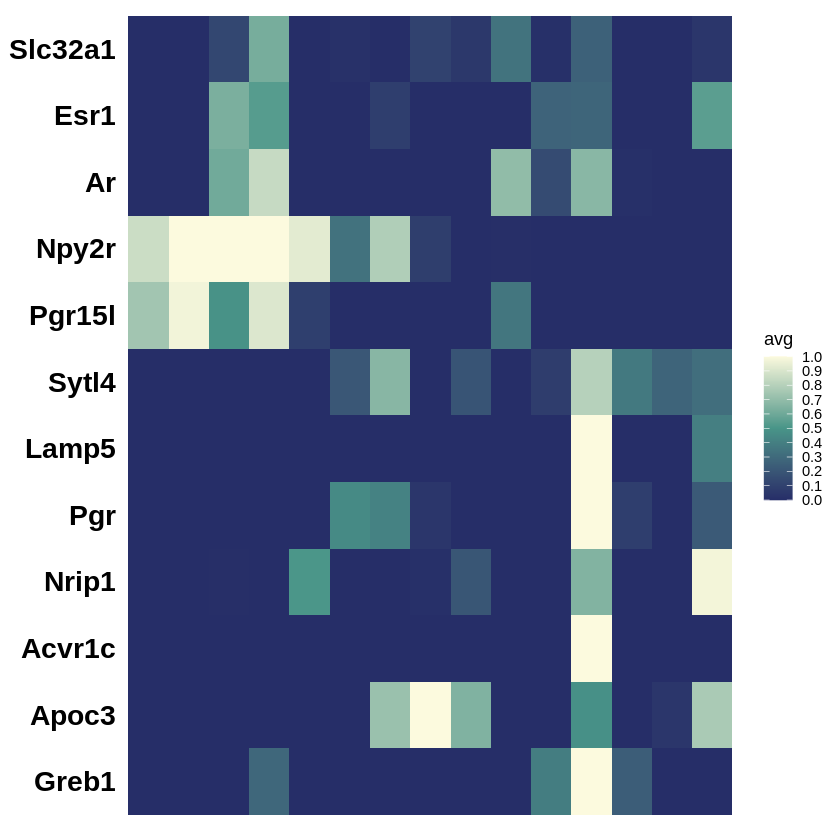

In [23]:
high_C<-"#FCFADE"
middle_C<-"#489588"
low_C<-"#262E68"
low<- 0
high<- 1
p<-ggplot(data = Cell_number, mapping = aes(x = cluster, y = gene,fill =avg)) +
  geom_tile() + scale_fill_gradient2(limits=c(low, high), breaks=seq(low,high,by=0.1),low = low_C,mid=middle_C,high =high_C,  midpoint = (low+high)/2,oob=squish)  #scale_fill_continuous(limits=c(low, high), breaks=seq(low,high,by=0.2),low = "black",high = "yellow", oob=squish)
pp<-p+ylab("gene")+xlab("psedutime")+theme(axis.text.y=element_text(size=17, colour = "black",face="bold"),axis.text.x=element_text(size=0,angle = 0, hjust =0.5,vjust=0.3,colour = "black"),axis.title=element_blank(),plot.title = element_blank(),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "white", size = 0),axis.ticks.y = element_blank(),axis.ticks.x = element_blank())+ggtitle("heatmap marker gene")
print(pp)
ggsave(file=paste(text="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/DEG_heatmap_light_DEGtrajectory_BL",dim,"_",low,"_",high,spacing,"Esr1",Esr1_threshold,"Vgat",Vgat_threshold,"color_adjusted.pdf"),width=10,height=7,paper="letter")
#dev.off()

In [2]:
# for svm
predicted_seq<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/predicted_seq_15.rds")

In [3]:
predicted_seq

,Sytl4,Acvr1c,Greb1,Nrip1,Lamp5,Apoc3,Pgr,Esr1,Slc32a1,Npy2r,Pgr15l,Ar,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TGGCCAGAGCCACTATP23M,1.819260,0.44924089,2.0079526,4.463020,2.355726,6.072851,12.50829,8.971044,16.23637,19.806121,14.257103,12.201652,P23M
CCGTTCAAGGGTATCGP23M,2.217862,0.15514919,1.1852770,8.379821,4.847991,2.632726,12.50895,11.080983,15.32380,19.044917,9.669033,18.065395,P23M
TTCCCAGAGGAATTACP23M,8.733805,0.61952371,1.2834959,6.566963,5.784933,3.739553,15.29325,13.913288,14.02572,7.238948,5.180734,12.066827,P23M
AAACGGGCACCACGTGP23M,3.287287,0.43179091,2.4460123,5.190292,4.467449,5.086477,13.76845,7.336830,21.89369,14.818979,8.740241,15.635959,P23M
AAGTCTGGTCTAGAGGP23M,1.676278,0.27181254,1.6792539,5.637736,2.605405,2.336611,10.40579,13.147462,13.19441,15.553986,6.860851,8.614591,P23M
AATCCAGTCCGAATGTP23M,2.172029,0.45376149,2.6582878,5.804305,6.980040,3.364471,11.14965,9.563091,18.43836,22.299845,14.355682,15.220072,P23M
ACACCGGGTTCCACAAP23M,3.615829,0.40095480,1.3711344,6.259332,8.488958,8.911550,19.29587,11.445896,17.22147,5.253294,6.376198,12.373855,P23M
ACATGGTTCCGTACAAP23M,3.749360,0.42283565,2.6810098,15.093896,16.022915,3.036312,12.19509,15.612066,19.83826,18.382263,12.798262,14.366021,P23M
ACTGAACAGAGGTTATP23M,2.661939,0.78490783,3.6953761,7.949968,9.050738,3.728630,12.86408,11.661564,18.76471,9.548436,12.521988,21.483312,P23M


In [4]:
Condition<-numeric()
for(i in 1:dim(predicted_seq)[1]){
   if(predicted_seq$group[i]=="AM" | predicted_seq$group[i]=="P35M" | predicted_seq$group[i]=="P28MT" ) {
       Condition[i]<-"mature"
   }else if (predicted_seq$group[i]=="P28MC" |predicted_seq$group[i]=="P23M" | predicted_seq$group[i]=="Cast" ) {
       Condition[i]<-"immature"
   }
}
predicted_seq$Condition<-Condition

In [5]:
write.xlsx2(predicted_seq,file=("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/svm/predicted/metadata_predicted.xlsx"))

# correlation between predicted and real seq data

In [2]:
MPOA.integrated<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/MPOA.integrated.rds")

new.ident <- c("Mix1","Vgat1","Vglu1","Vgat2","Vgat3","Vgat4","Mix2","Vglu2","Vgat5","Vglu3","Vglu4","Vgat6","Vgat7","Vgat8","Vglu5","Vglu6","Vgat9","Vgat10","Vgat11","Vglu7","Vgat12","Vgat13","Vgat14","Vgat15","Vglu8","Vglu9","Vgat16","Vglu10","Vgat17","Vgat18","Vgat19","Vglu11","Vglu12","Ambiguous1","Mix3","Vgat20")
names(x = new.ident) <- levels(x =MPOA.integrated)
MPOA.integrated<- RenameIdents(object =MPOA.integrated, new.ident)
MPOA.integrated<-subset(MPOA.integrated,cells=rownames(subset(MPOA.integrated@meta.data,stim=="AM"|stim=="P35M"|stim=="P23M"|stim=="Cast")))
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(MPOA.integrated@assays$RNA@data[,which(Idents(object=MPOA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
}
Hormone_rich<-c(Vgat2_barcode,Vgat4_barcode,Vgat16_barcode)
BC<-intersect(rownames(MPOA.integrated@meta.data),Hormone_rich)
MPOA.integrated<-subset(MPOA.integrated,cells=BC)

In [3]:
predicted_seq<-readRDS("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/predicted_seq_15.rds")

In [4]:
predicted_seq<-predicted_seq[,1:12]

In [5]:
predicted_seq<-log(predicted_seq+1)# for visualization, in monocle I am not using normalized data

In [74]:
# this is for including all genes not use in the paper
corr <-  data.frame(Date=as.Date(character()),
                 File=character(), 
                 User=character(), 
                 stringsAsFactors=FALSE) 
for(i in 1:12){
temp<-data.frame(name=rownames(predicted_seq),predicted=predicted_seq[,i],real=MPOA.integrated@assays$RNA@data[colnames(predicted_seq[i]),rownames(predicted_seq)])
corr<-rbind(corr,temp)    
}
ggplot(corr,aes(x=real,y=predicted))+geom_point(size=0.2,color='darkblue') +geom_smooth(method = "lm", se = FALSE,color="black", fill="orange")+ylim(0,35)+xlab("real scRNAseq expression")+ylab("predicted expression")+
theme(axis.text.x=element_text(size=40, hjust = 0.5,color="black"),axis.text.y=element_text(size=40, hjust = 1,color="black"),axis.title=element_text(size=40,face="bold"),axis.title.x=element_text(size=50,face="bold",color="black"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(),axis.line = element_line(colour = "black",size=2),axis.ticks.length=unit(.3, "cm"),axis.ticks = element_line(size = 2), plot.margin = margin(10, 47, 5,5))
#geom_text( aes(x = 0, y = 50), hjust = 0,label =R2.exp,size=11)+
#geom_text( aes(x = 0, y = 40), hjust = 0,label = paste("P =",signif(summary(fit1)$coef[2,4], 2)),size=11)

ggsave(file="/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/correlation.pdf",width=5,height=6)

In [6]:
options(digits = 5) 

In [7]:
predicted_seq

,Sytl4,Acvr1c,Greb1,Nrip1,Lamp5,Apoc3,Pgr,Esr1,Slc32a1,Npy2r,Pgr15l,Ar
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TGGCCAGAGCCACTATP23M,1.03647,0.371040,1.10126,1.6980,1.2107,1.95626,2.6033,2.2997,2.8470,3.0352,2.7250,2.5803
CCGTTCAAGGGTATCGP23M,1.16872,0.144230,0.78174,2.2386,1.7661,1.28998,2.6034,2.4916,2.7926,2.9980,2.3673,2.9479
TTCCCAGAGGAATTACP23M,2.27560,0.482132,0.82571,2.0238,1.9147,1.55594,2.7908,2.7023,2.7098,2.1089,1.8214,2.5701
AAACGGGCACCACGTGP23M,1.45565,0.358926,1.23722,1.8230,1.6988,1.80607,2.6925,2.1207,3.1309,2.7612,2.2763,2.8116
AAGTCTGGTCTAGAGGP23M,0.98443,0.240443,0.98554,1.8928,1.2824,1.20496,2.4341,2.6495,2.6528,2.8066,2.0619,2.2633
AATCCAGTCCGAATGTP23M,1.15437,0.374154,1.29700,1.9176,2.0769,1.47350,2.4973,2.3574,2.9672,3.1484,2.7315,2.7862
ACACCGGGTTCCACAAP23M,1.52949,0.337154,0.86337,1.9823,2.2501,2.29370,3.0104,2.5214,2.9026,1.8331,1.9983,2.5933
ACATGGTTCCGTACAAP23M,1.55801,0.352652,1.30319,2.7784,2.8346,1.39533,2.5798,2.8101,3.0368,2.9644,2.6245,2.7322
ACTGAACAGAGGTTATP23M,1.29799,0.579367,1.54658,2.1916,2.3076,1.55364,2.6293,2.5386,2.9839,2.3560,2.6043,3.1128


In [8]:
# individulally compute correlation, used in the paper


corr_coeff<-numeric()
p<-numeric()

for(i in 1:dim(predicted_seq)[2]){
corr <-  data.frame(Date=as.Date(character()),
                 File=character(), 
                 User=character(), 
                 stringsAsFactors=FALSE) 
corr<-data.frame(name=rownames(predicted_seq),predicted=predicted_seq[,i],real=MPOA.integrated@assays$RNA@data[colnames(predicted_seq[i]),rownames(predicted_seq)])
corr_coeff<-c(corr_coeff,cor(corr$predicted,corr$real))
p<-c(p,cor.test(corr$predicted,corr$real)$p.value)    
gene<-colnames(predicted_seq)[i]

ggplot(corr,aes(x=real,y=predicted))+geom_point(size=1,color='darkblue') +geom_smooth(method = "lm", se = FALSE,color="black", fill="orange")+ylim(0,4)+xlab("real scRNAseq expression")+ylab("predicted expression")+
theme(axis.text.x=element_text(size=30, hjust = 0.5,color="black"),axis.text.y=element_text(size=30, hjust = 1,color="black"),axis.title=element_text(size=30,face="bold"),axis.title.x=element_text(size=30,face="bold",color="black"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(),axis.line = element_line(colour = "black",size=2),axis.ticks.length=unit(.3, "cm"),axis.ticks = element_line(size = 2), plot.margin = margin(10, 47, 5,5))+ggtitle(gene)+
geom_text( aes(x =0 , y = 4), hjust = 0,label =paste("corr=",cor(corr$predicted,corr$real)),size=7)+
geom_text( aes(x = 0, y = 3.7), hjust = 0,label = paste("P =",cor.test(corr$predicted,corr$real)$p.value),size=7)

ggsave(file=paste("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/correlation/correlation",gene,".pdf",sep=""),width=5,height=7)
}
corr_data<-data.frame(name=colnames(predicted_seq),correlation_coeff=corr_coeff,pvalue=p)
write.xlsx2(corr_data,file=("/media/garret/New Volume/scRNAseq_data/Koichi/HCR/male/predicted/seq/correlation/correlation.xlsx"))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

